# Plot times series of sea ice volume, integrated over continental shelf 

Show together with 'total melt' time series, idea is: more sea ice formation + constant sea ice volume -> more sea ice export

Sea ice volume: `vi = hi * aice`

Experiments:
- Control
- WIND+
- WIND-
- WIND+zonal
- WIND+merid

In [1]:
%matplotlib inline

import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
#import glob, os
import cmocean.cm as cm
#import xgcm
from datetime import timedelta

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:45159 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 44.92 GiB


In [39]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
easterlies_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'
# WIND+zonal
easterlies_up_zonal = '01deg_jra55v13_ryf9091_easterlies_up10_zonal'
# WIND+merid
easterlies_up_merid = '01deg_jra55v13_ryf9091_easterlies_up10_meridional'

start_time ='2150-01-01'
end_time   ='2160-12-31'
#time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

In [17]:
lat_slice = slice(-90,-59)
lon_slice = slice(-280,80)
isobath_depth = 1000

### Import sea ice data

In [10]:
# Get grid info
area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)

In [35]:
def import_vi(exp):
    """
    0: control
    1: WIND+
    2: WIND-
    3: WIND+zonal
    4: WIND+merid
    """
    if exp == 0:
        # Control
        # Sea ice concentration
        aice = cc.querying.getvar(control, 'aice_m', master_session, start_time=start_time, end_time=end_time, decode_coords=False)
        # Sea ice height
        hi   = cc.querying.getvar(control, 'hi_m', master_session, start_time=start_time, end_time=end_time, decode_coords=False)
    elif exp == 1:
        # WIND+
        aice = cc.querying.getvar(easterlies_up, 'aice_m', easterlies_session, start_time=start_time, end_time=end_time, decode_coords=False) 
        hi   = cc.querying.getvar(easterlies_up, 'hi_m', easterlies_session, start_time=start_time, end_time=end_time, decode_coords=False)
    elif exp == 2:
        # WIND-
        aice = cc.querying.getvar(easterlies_down, 'aice_m', easterlies_session, start_time=start_time, end_time=end_time, decode_coords=False) 
        hi   = cc.querying.getvar(easterlies_down, 'hi_m', easterlies_session, start_time=start_time, end_time=end_time, decode_coords=False)
    elif exp == 3:
        # WIND+zonal
        aice = cc.querying.getvar(easterlies_up_zonal, 'aice_m', easterlies_session, start_time=start_time, end_time=end_time, decode_coords=False) 
        hi   = cc.querying.getvar(easterlies_up_zonal, 'hi_m', easterlies_session, start_time=start_time, end_time=end_time, decode_coords=False)
    elif exp == 4:
        # WIND+merid
        aice = cc.querying.getvar(easterlies_up_merid, 'aice_m', easterlies_session, start_time=start_time, end_time=end_time, decode_coords=False) 
        hi   = cc.querying.getvar(easterlies_up_merid, 'hi_m', easterlies_session, start_time=start_time, end_time=end_time, decode_coords=False)

        
    # Move time 12 hr forward to make sure it is in the correct month
    aice['time'] = aice.time.to_pandas() - timedelta(hours = 12)
    hi['time']   = hi.time.to_pandas() - timedelta(hours = 12)
    
    # Rename coordinates
    # t-grid
    aice.coords['ni'] = area_t['xt_ocean'].values
    aice.coords['nj'] = area_t['yt_ocean'].values
    aice = aice.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    hi.coords['ni'] = area_t['xt_ocean'].values
    hi.coords['nj'] = area_t['yt_ocean'].values
    hi = hi.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    
    # Calculate sea ice volume, convert to km^3 and rename dataarray
    vi = aice * area_t * hi * 1e-9
    vi = vi.rename('vi')
    
    # Select latitude and time range
    vi   = vi.sel(yt_ocean=lat_slice).sel(time=slice(start_time, end_time))

    # Finished
    return vi

In [40]:
vi_control  = import_vi(0)
vi_up       = import_vi(1)
vi_down     = import_vi(2)
vi_up_zonal = import_vi(3)
vi_up_merid = import_vi(4)

### Mask continental shelf

In [31]:
# shelf masking:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

In [41]:
# Multiply the variable with the mask, we need to account for the shape of the mask. 
# The mask uses a northern cutoff of 59S.
vi_control  = vi_control * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
vi_up       = vi_up * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
vi_down     = vi_down * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
vi_up_zonal = vi_up_zonal * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
vi_up_merid = vi_up_merid * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

In [43]:
vi_control  = vi_control.load()
vi_up       = vi_up.load()
vi_down     = vi_down.load()
vi_up_zonal = vi_up_zonal.load()
vi_up_merid = vi_up_merid.load()

In [52]:
# Circumpolar integral
vi_control_cpolar  = vi_control.sum('xt_ocean').sum('yt_ocean')
vi_up_cpolar       = vi_up.sum('xt_ocean').sum('yt_ocean')
vi_down_cpolar     = vi_down.sum('xt_ocean').sum('yt_ocean')
vi_up_zonal_cpolar = vi_up_zonal.sum('xt_ocean').sum('yt_ocean')
vi_up_merid_cpolar = vi_up_merid.sum('xt_ocean').sum('yt_ocean')

In [55]:
# Annual mean 
vi_control_cpolar_a  = vi_control_cpolar.groupby('time.year').mean('time')
vi_up_cpolar_a       = vi_up_cpolar.groupby('time.year').mean('time')
vi_down_cpolar_a     = vi_down_cpolar.groupby('time.year').mean('time')
vi_up_zonal_cpolar_a = vi_up_zonal_cpolar.groupby('time.year').mean('time')
vi_up_merid_cpolar_a = vi_up_merid_cpolar.groupby('time.year').mean('time')

In [63]:
# Annual sum 
vi_control_cpolar_sum  = vi_control_cpolar.groupby('time.year').sum('time')
vi_up_cpolar_sum       = vi_up_cpolar.groupby('time.year').sum('time')
vi_down_cpolar_sum     = vi_down_cpolar.groupby('time.year').sum('time')
vi_up_zonal_cpolar_sum = vi_up_zonal_cpolar.groupby('time.year').sum('time')
vi_up_merid_cpolar_sum = vi_up_merid_cpolar.groupby('time.year').sum('time')

### Plotting

In [61]:
# Figure path
fig_path = '/g/data/x77/wgh581/Figures/Easterlies-Collab/'
# Month labels
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# Panel labels
panel_name = ['A', 'B', 'C', 'D', 'E', 'F']
# Font size
plt.rcParams['font.size'] = 14
# Axes
plt.rcParams['axes.facecolor']  = 'white'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
# Saving parameters
plt.rcParams['savefig.dpi']  = 150
plt.rcParams['savefig.bbox'] = 'tight'

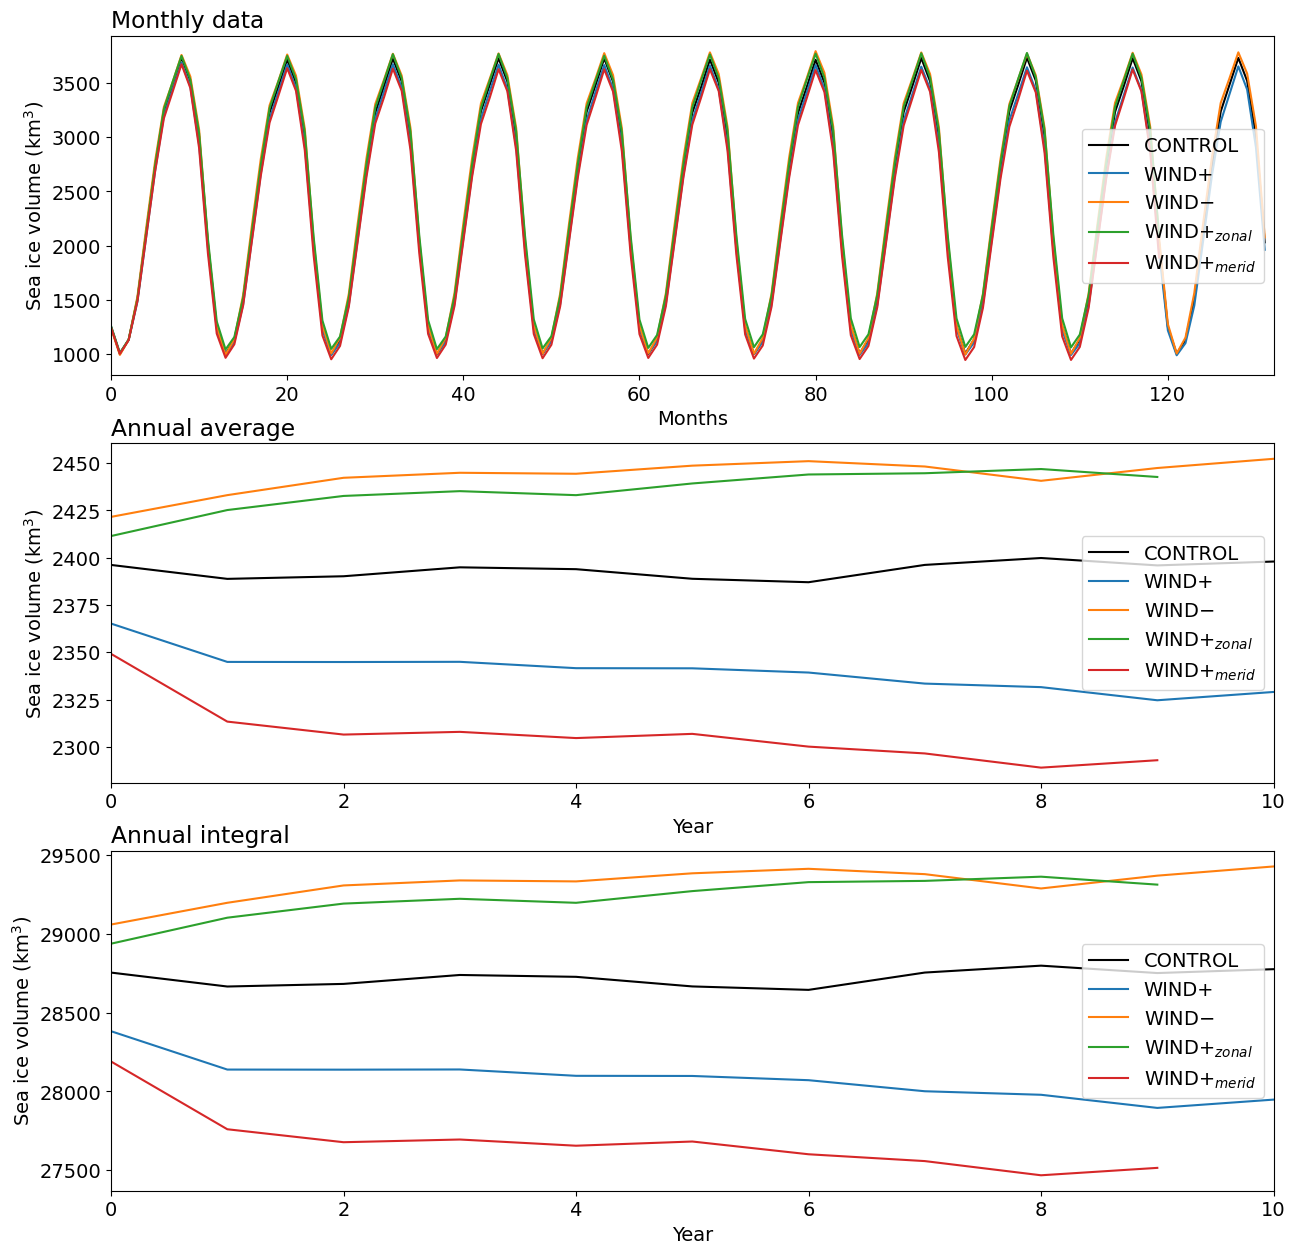

In [70]:
fig = plt.figure(figsize=(15,15))

plt.subplot(311)
plt.title('Monthly data', loc='left')
plt.plot(vi_control_cpolar, color='k', label='CONTROL')
plt.plot(vi_up_cpolar, color='C0', label='WIND+')
plt.plot(vi_down_cpolar, color='C1', label='WIND$-$')
plt.plot(vi_up_zonal_cpolar, color='C2', label='WIND+$_{zonal}$')
plt.plot(vi_up_merid_cpolar, color='C3', label='WIND+$_{merid}$')
plt.legend()
plt.xlabel('Months')
plt.ylabel('Sea ice volume (km$^3$)')
plt.xlim(0,132)

plt.subplot(312)
plt.title('Annual average', loc='left')
plt.plot(vi_control_cpolar_a, color='k', label='CONTROL')
plt.plot(vi_up_cpolar_a, color='C0', label='WIND+')
plt.plot(vi_down_cpolar_a, color='C1', label='WIND$-$')
plt.plot(vi_up_zonal_cpolar_a, color='C2', label='WIND+$_{zonal}$')
plt.plot(vi_up_merid_cpolar_a, color='C3', label='WIND+$_{merid}$')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sea ice volume (km$^3$)')
plt.xlim(0, 10)

plt.subplot(313)
plt.title('Annual integral', loc='left')
plt.plot(vi_control_cpolar_sum, color='k', label='CONTROL')
plt.plot(vi_up_cpolar_sum, color='C0', label='WIND+')
plt.plot(vi_down_cpolar_sum, color='C1', label='WIND$-$')
plt.plot(vi_up_zonal_cpolar_sum, color='C2', label='WIND+$_{zonal}$')
plt.plot(vi_up_merid_cpolar_sum, color='C3', label='WIND+$_{merid}$')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sea ice volume (km$^3$)')
plt.xlim(0, 10)

# Finished
save_flag = 0
if save_flag == 1:
    fig_name = 'Fig_seaicevolume_timeseries.png'
    plt.savefig(fig_path + fig_name)

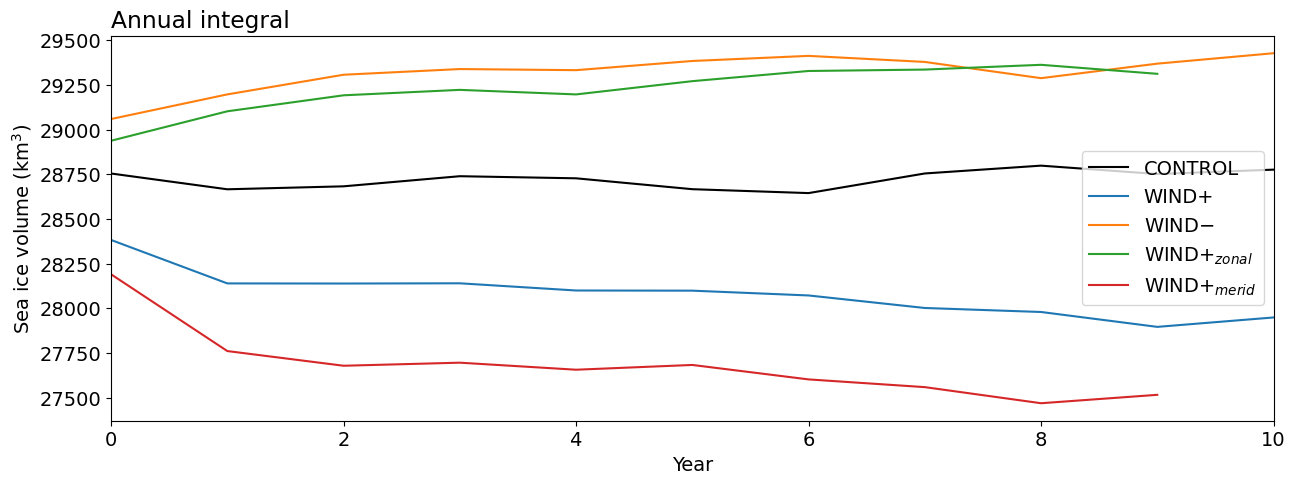

In [71]:
fig = plt.figure(figsize=(15,5))

plt.subplot(111)
plt.title('Annual integral', loc='left')
plt.plot(vi_control_cpolar_sum, color='k', label='CONTROL')
plt.plot(vi_up_cpolar_sum, color='C0', label='WIND+')
plt.plot(vi_down_cpolar_sum, color='C1', label='WIND$-$')
plt.plot(vi_up_zonal_cpolar_sum, color='C2', label='WIND+$_{zonal}$')
plt.plot(vi_up_merid_cpolar_sum, color='C3', label='WIND+$_{merid}$')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sea ice volume (km$^3$)')
plt.xlim(0, 10)

# Finished
save_flag = 0
if save_flag == 1:
    fig_name = 'Fig_seaicevolume_timeseries_annual.png'
    plt.savefig(fig_path + fig_name)